In [1]:
!pip -q install rectools

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.0/99.0 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 79.5 MB/s eta 0:00:00


In [2]:
import time
import tqdm
import hashlib
import datetime
import zipfile as zf
import requests
import logging
import collections
import numpy as np
import seaborn as sns
import pandas as pd
from tqdm.auto import tqdm
from IPython.display import display
from matplotlib import pyplot as plt
from random import choice
from scipy.stats import norm
from copy import deepcopy, copy
from typing import Dict, List, Tuple, Union, Callable, Any

In [3]:
import rectools
from rectools.dataset import Interactions, Dataset, DenseFeatures
from rectools.model_selection import Splitter, TimeRangeSplitter
from rectools.models.base import ModelBase
from rectools.models import RandomModel, PopularModel
from rectools.metrics.base import MetricAtK
from rectools.metrics import (
    Precision,
    Recall,
    MAP,
    NDCG,
    Serendipity,
    MeanInvUserFreq,
    IntraListDiversity,
    PairwiseHammingDistanceCalculator,
    calc_metrics,
)

/usr/local/lib/python3.10/dist-packages/implicit/gpu/__init__.py:13: UserWarning: CUDA extension is built, but disabling GPU support because of 'Cuda Error: CUDA driver version is insufficient for CUDA runtime version (/project/./implicit/gpu/utils.h:71)'
  warnings.warn(


In [4]:
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_columns', 1000)
pd.set_option('display.max_rows', 20000)

<ipython-input-4-57f4fc94f2aa>:1: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


## Загрузка данных

In [5]:
url = 'https://github.com/irsafilo/KION_DATASET/raw/f69775be31fa5779907cf0a92ddedb70037fb5ae/data_original.zip'
request = requests.get(url, stream=True)

with open('kion.zip', 'wb') as fd:
  total_sipe_in_bytes = int(request.headers.get('Content-Length', 0))
  progress_bar = tqdm(desc='KION dataset download', total=total_sipe_in_bytes, unit='iB', unit_scale=True)
  for chunk in request.iter_content(chunk_size= 2 ** 20):
    progress_bar.update(len(chunk))
    fd.write(chunk)

KION dataset download:   0%|          | 0.00/78.8M [00:00<?, ?iB/s]

In [6]:
files = zf.ZipFile('kion.zip', 'r')
files.extractall()
files.close()

## Считаем нужные нам данные
---
И проведем предобработку


In [7]:
interactions = pd.read_csv('/content/data_original/interactions.csv')
users = pd.read_csv('/content/data_original/users.csv')
items = pd.read_csv('/content/data_original/items.csv')

In [8]:
interactions.head(5).append(interactions.tail())

# Здесь total_dur = "смотрение"

<ipython-input-8-bc02faefa06b>:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  interactions.head(5).append(interactions.tail())


,user_id,item_id,last_watch_dt,total_dur,watched_pct
0,176549,9506,2021-05-11,4250,72.0
1,699317,1659,2021-05-29,8317,100.0
2,656683,7107,2021-05-09,10,0.0
3,864613,7638,2021-07-05,14483,100.0
4,964868,9506,2021-04-30,6725,100.0
5476246,648596,12225,2021-08-13,76,0.0
5476247,546862,9673,2021-04-13,2308,49.0
5476248,697262,15297,2021-08-20,18307,63.0
5476249,384202,16197,2021-04-19,6203,100.0
5476250,319709,4436,2021-08-15,3921,45.0


In [9]:
# предобработка данных
interactions['last_watch_dt'] = pd.to_datetime(interactions['last_watch_dt']).map(lambda x: x.date())
interactions['user_id'] = interactions['user_id'].astype(str)

print(f"Уникальных юзеров в interactions: {interactions['user_id'].nunique():_}")
print(f"Уникальных айтемов в interactions: {interactions['item_id'].nunique():_}")

Уникальных юзеров в interactions: 962_179
Уникальных айтемов в interactions: 15_706


Переод времени данных

In [10]:
max_date = interactions['last_watch_dt'].max()
min_date = interactions['last_watch_dt'].min()
print(min_date, max_date)

2021-03-13 2021-08-22


Выделим данные для двух недель и для одной недели

In [11]:
# выделим данные за одну неделю
week1 = interactions[interactions['last_watch_dt'] >= max_date - datetime.timedelta(days=7)]
week1 = week1.groupby('user_id', as_index=False).agg({'total_dur': sum})

# выделим данные за две недели
week2 = interactions[interactions['last_watch_dt'] >= max_date - datetime.timedelta(days=14)]
week2 = week2.groupby('user_id', as_index=False).agg({'total_dur': sum})

Посмотрим на смотрение

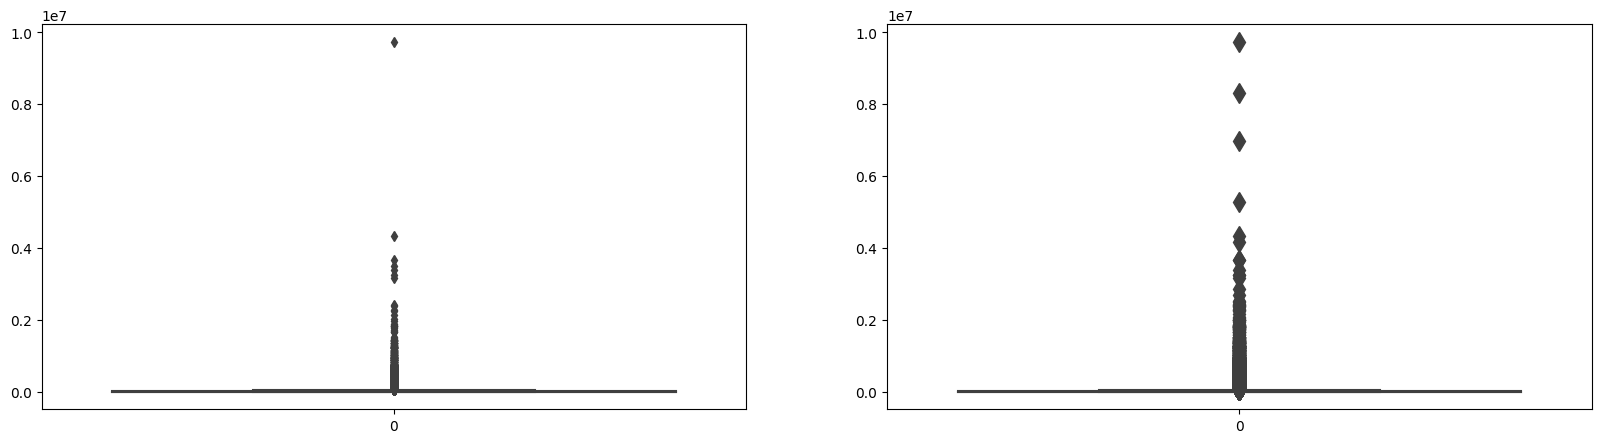

In [12]:
plt.rcParams["figure.figsize"] = [20.00, 5.00]
fig, ax = plt.subplots(1,2)
sns.boxplot(week1['total_dur'].values, fliersize=5, ax=ax[0])
sns.boxplot(week2['total_dur'].values, fliersize=10, ax=ax[1])
fig.show()

In [13]:
# Выбрасываем выбросы в смотрении
week1 = week1[(week1['total_dur'] < week1['total_dur'].std() * 3)]
week2 = week2[(week2['total_dur'] < week2['total_dur'].std() * 3)]

Опять смотрим на смотрение

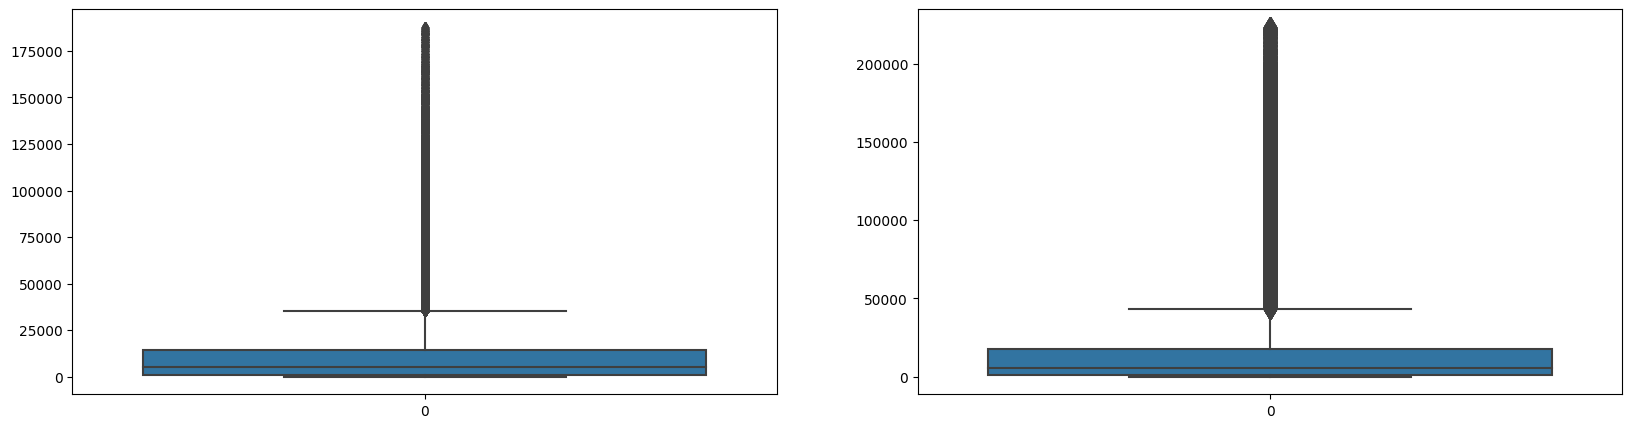

In [14]:
plt.rcParams["figure.figsize"] = [20.00, 5.00]
fig, ax = plt.subplots(1,2)
sns.boxplot(week1['total_dur'].values, fliersize=5, ax=ax[0])
sns.boxplot(week2['total_dur'].values, fliersize=10, ax=ax[1])
fig.show()

# Со смотрением все хорошо

## Функция, возвращающая соль из задания

In [15]:
def get_salt():
  return 'kiontestmodel20210805'

## Разбивка на группы при помощи соли

In [16]:
def groups_splitter(df, columns, salt):
  # Считаем хэш для соли, временная колонка
  df['hash'] = ((df['user_id'].astype(str)) + '#' + salt).apply(lambda x: hashlib.sha256(x.encode('utf-8')).hexdigest())
  # Считаем группу
  df['group'] = (df['hash'].str.slice(start=-6).apply(int, base=16) % 2).map(lambda x: 'A' if x == 0 else 'B')
  # Дропаем временную колонку
  df = df.drop(columns=['hash'])
  # Вернуть без дупликатов
  return df[columns].drop_duplicates()

In [17]:
groups_w1 = groups_splitter(week1.copy(), ['user_id', 'group'], get_salt()) # передаем копию датафрейма, чтобы исходный не менялся
week1_df = pd.merge(week1, groups_w1, how='left', on=['user_id']) # джойним датафрейм с логами с датафреймом юзер-группа

groups_w2 = groups_splitter(week2.copy(), ['user_id', 'group'], get_salt()) # передаем копию датафрейма, чтобы исходный не менялся
week2_df = pd.merge(week2, groups_w2, how='left', on=['user_id']) # джойним датафрейм с логами с датафреймом юзер-группа

In [18]:
week2_df.head(5).append(week2_df.tail())

# Все разделилось и посолилось

<ipython-input-18-810505d72648>:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  week2_df.head(5).append(week2_df.tail())


,user_id,total_dur,group
0,1,21172,B
1,1000,10744,B
2,1000000,33776,B
3,1000001,52,B
4,1000003,625,A
275611,999978,29615,A
275612,999987,27888,A
275613,999989,4563,B
275614,999990,997,B
275615,999993,17228,A


## Некоторые методы, нужные для bootstrap
---
Смотрение не распределено нормально и ни один из критериев нам не подходит

In [19]:
def get_bootstrap_array(arr):
    return np.random.choice(arr, replace=True, size=len(arr))

def calc_bootstrap_mean(arr, size=1000):
    result = np.empty(size)
    for i in range(size):
        result[i] = np.mean(get_bootstrap_array(arr))
    return result

def get_p_value(dist):
  dist = np.array(dist)
  x = (dist > 0).mean()
  p_value = min(x, 1 - x) * 2
  return p_value

In [20]:
class Смотрение:
    def __init__(self, dfs, iterations=1000):
        self.dfs = dfs
        self.iterations = iterations

    def fit(self, effects=[1]):
      metrics = []
      for df in self.dfs:
        correctness = []
        values = []

        for effect in effects:
          for i in tqdm(range(self.iterations)):

            new_df = groups_splitter(df.copy(), columns=['user_id', 'total_dur', 'group'], salt=get_salt()).drop_duplicates()

            vec_a = new_df[(new_df['group'] == 'A')]['total_dur']
            vec_b = new_df[(new_df['group'] == 'B')]['total_dur']

            #bootstrap считаем средние для вектора
            sample_a_mean = calc_bootstrap_mean(vec_a, size=1000)
            sample_b_mean = calc_bootstrap_mean(vec_b, size=1000)

            # Добавить эффект, если считаем мощность
            if effect:
              sample_b_mean = sample_b_mean * effect

            values.append(sample_a_mean - sample_b_mean)
            # считаем 95% доверительный интервал для разницы средних
            left_side, right_side = np.percentile(sample_a_mean - sample_b_mean, [100 * 0.05 / 2., 100 * (1 - 0.05 / 2.)])

            correctness.append(not left_side <= 0 <= right_side)
            test_correctness = collections.Counter(correctness)

          metric = test_correctness[1]/(test_correctness[1] + test_correctness[0])*100
          metrics.append({
              'metric': metric,
              'effect': effect,
              'correctness': correctness,
              'values': values
          })
      return metrics

In [21]:
smotrenie = Смотрение([week1, week2])
res = smotrenie.fit()

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

In [22]:
for7 = res[0]['metric']
for14 = res[1]['metric']

print(f'Для 7и дней корректность {for7}%')
print(f'Для 14и дней корректность {for14}%')

Для 7и дней корректность 0.0%
Для 14и дней корректность 0.0%


## На двух неделях посчитаем мощность

In [23]:
smotrenie = Смотрение([week2])
res = smotrenie.fit([0.01, 0.03, 0.05])

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

In [24]:
effect001 = res[0]['metric']
effect003 = res[1]['metric']
effect005 = res[2]['metric']

print(f'На 14и днях мощность с эффектом 0.01 = {effect001}')
print(f'На 14и днях мощность с эффектом 0.03 = {effect003}')
print(f'На 14и днях мощность с эффектом 0.05 = {effect005}')

На 14и днях мощность с эффектом 0.01 = 100.0
На 14и днях мощность с эффектом 0.03 = 100.0
На 14и днях мощность с эффектом 0.05 = 100.0


## Посчитаем MDE для двух недель

In [25]:
def get_mde(metric_vec, alpha=0.05, beta=0.2):

    metric_mean, metric_std, metric_n = metric_vec.mean(), metric_vec.std(), metric_vec.count()

    z_alpha = norm.ppf(1 - (alpha / 2), loc=0, scale=1)
    z_beta = norm.ppf(1 - beta, loc=0, scale=1)

    mde = (z_alpha + z_beta)*metric_std / np.sqrt(metric_n)

    return mde*100/metric_mean

In [26]:
mde = get_mde(week2['total_dur'], 0, 0)

In [27]:
mde

inf

Получилась бесконечная мощность, так совпало, что мы не нашли отличий там, где них нет, и нашли везде, где они были

## Проведем А\В тест

In [28]:
week2c = week2.copy()

Занулите для всех пользователей total_dur, у которых total_dur < 500

In [31]:
week2c['total_dur'] = week2c['total_dur'].apply(lambda x: x if x >= 500 else 0)
new_week2 = groups_splitter(week2c.copy(), columns=['user_id', 'total_dur', 'group'], salt=get_salt()).drop_duplicates()

Разбейте их самостоятельно на две равные группы, используйте функцию groups_splitter и соль = 'kiontestmodel20210805'

In [34]:
A = new_week2[new_week2['group'] == 'A']
B = new_week2[new_week2['group'] == 'B']

Оказалось, что модель в группе В показала себя лучше, чем в группе А на 2.5%, причем эффект распространился неравномерно и преимущественно на 10% самых смотрящих пользователей, докиньте такой эффект самостоятельно.

In [51]:
# отсортировать по убыванию
B = B.sort_values('total_dur', ascending=False)
# зафиксировать смотрение
смотрение = B['total_dur']
# посчитать сколько будет 10%
ten_percent = int(смотрение.size * 0.1)
# взять из смотрения топ 10% смотрящих юзеров
top_10_percent = смотрение[0: ten_percent]
# взять все оствльное
other = смотрение[(ten_percent + 1) :]
# добавить эффект 2.5%
top_10_percent_effect = top_10_percent * 0.025
# соединить обратно 10% смотрящих с добавленным эффектом и докинуть остальных
concat = pd.concat([top_10_percent_effect,other])

In [53]:
B = B.drop(columns=['total_dur'])
# Теперь в группе В смотрение увеличилось
B['total_dur'] = concat

### Bootstrap

In [55]:
sample_a_mean = calc_bootstrap_mean(A['total_dur'], size=1000)
sample_b_mean = calc_bootstrap_mean(B['total_dur'], size=1000)
value = sample_a_mean - sample_b_mean

left_side, right_side = np.percentile(sample_a_mean - sample_b_mean,
                                                  [100 * 0.05 / 2., 100 * (1 - 0.05 / 2.)]) # считаем 95% доверительный интервал для разницы средних

res = not left_side <= 0 <= right_side

In [58]:
if res:
  print('Мы нашли статистически значимые изменения')
else:
  print('Мы ничего не нашли(((')

Мы нашли статистически значимые изменения
